# Regression prediction of homes prices

# 0. Import packages and training files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_selection as fs
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from math import sqrt
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

%config InlineBackend.figure_format = 'png'
%matplotlib inline
sns.set()
file1 = '../../datasets/ames-iowa-housing-prices-dataset/train1.csv'
file2 = '../../datasets/ames-iowa-housing-prices-dataset/test1.csv'

In [2]:
train = pd.read_csv(file1)
test = pd.read_csv(file2)

# 1. Explore relationships of target variable, SalePrice and features within dataset

In [3]:
len(train.columns)
train.shape[0]

1460

In [4]:
# Check out our features
train.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

count      1459.000000
mean     180935.535298
std       79467.851763
min       34900.000000
25%      129950.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


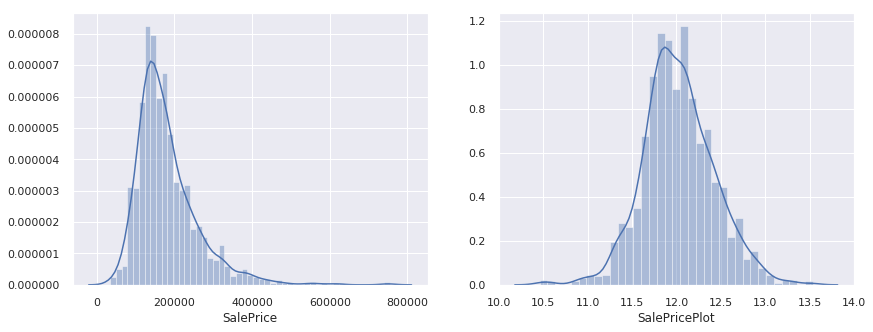

In [29]:
#sns.distplot(train['SalePrice'])
print(train['SalePrice'].describe())
# set up our figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.distplot(train.SalePrice, ax=axes[0])
train['SalePricePlot'] = np.log1p(train.SalePrice)
sns.distplot(train.SalePricePlot, ax=axes[1])



## 1.1 Plot Correlation Matrix to visualize relevant features

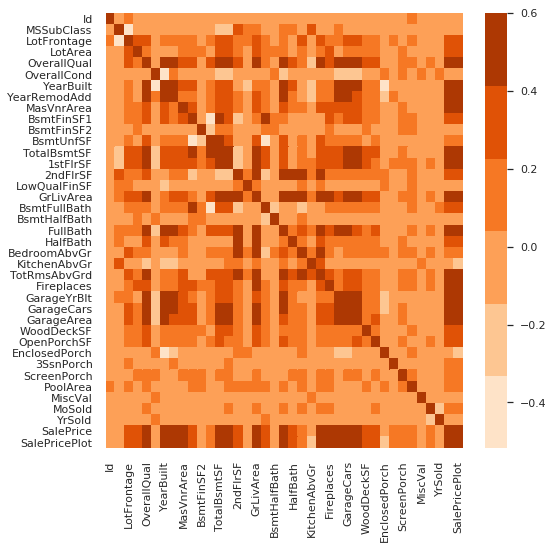

In [30]:
corrmat = train.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, vmax=.6, cmap=sns.color_palette("Oranges"))

### Lets inspect some relationships between Variables and SalePrice


In [31]:
def plot_with_trend(x,y,title=None):
    z=np.polyfit(x,y,3)
    p = np.poly1d(z)
    plt.figure(figsize=(8,5))
    plt.xlabel("1st floor Sq ft")
    plt.ylabel("Sale Price")
    plt.plot( x, p(x), marker='*')
    plt.scatter(x, y, c='r', marker='+')

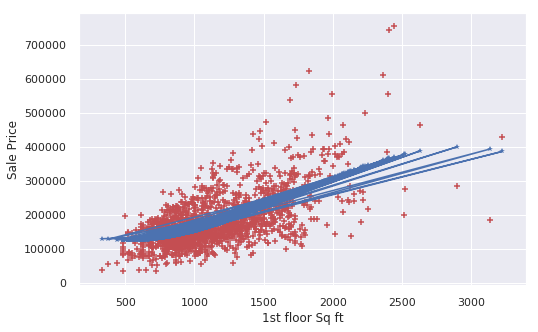

In [32]:
x = train['1stFlrSF']
y = train.SalePrice
plot_with_trend(train['1stFlrSF'], train.SalePrice, title="Looking for Outliers")
df_slice = train.copy(deep=True)

# 2. Prepare Data, Select features

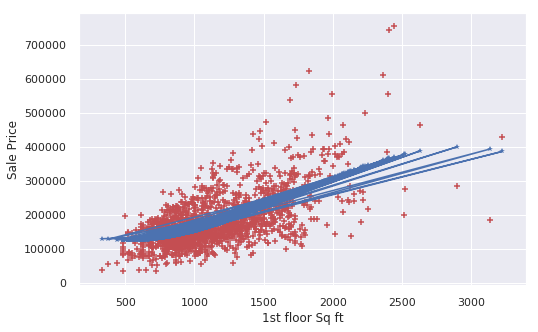

In [33]:
# lets plot that again after removing some outliers
train = train[train['1stFlrSF']<4000]
plot_with_trend(train['1stFlrSF'], train.SalePrice, title="Removed > 400sf")

In [34]:
temp_slice = train.copy(deep=True)


We can see after removing that single outlier how much our linear fit changed

# 2.1 Feature selection
We will try a simple analysis using the most highly correlated values and see what kind of results we get (turns out they were pretty good!)

In [35]:

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Note to self, don't accidentally include the target feature in the training data set!!!
train.corr().SalePrice.sort_values(ascending=False)
# remove saleprice and log plot in 1st position
features = [a for a in train.corr().SalePrice.sort_values(ascending=False)[2:12].index]
features

['OverallQual',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'GarageArea',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

In [36]:

# sns.pairplot(train[features], height=2.0)
# plt.show()

## 3. Modeling
Here we will define some convenience methods for later

In [37]:
def dtree_fit(X_train, X_test, y_train, y_test, plot=None):
    regressor = DecisionTreeRegressor(max_depth=75, max_leaf_nodes=125)
    regressor.fit(X_train, y_train)
    y_prediction_dt = regressor.predict(X_test)
    decision_tree_RMSE=sqrt(mean_squared_error(y_true=y_test, y_pred=y_prediction_dt))
    if plot:
        plt.scatter(y_test,y_prediction_dt)
        plt.title("Decision Tree Results")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        return
    return [decision_tree_RMSE, y_prediction_dt]

### 3.1 Leaf/Depth tuning

In [38]:
def get_mae_depth(max_depth, X_train, X_test, y_train, y_test):
    model = DecisionTreeRegressor(max_depth=max_max_depth, random_state=0)
    model.fit(X_train, y_train)
    prediction_value = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction_value)
    return mae

In [39]:
def get_mae(max_leaf_nodes, X_train, X_test, y_train, y_test):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(X_train, y_train)
    prediction_value = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction_value)
    return mae

In [40]:
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
for max_leaves in [5,50,100, 150, 900, 5000]:
    mae = get_mae(max_leaves, X_train, X_test, y_train, y_test)
    print(f"Max leaf nodes: {max_leaves} \t\t Mean Absolute Error: {mae} ")
print("\n")
for max_depth in [5,10,15, 25, 50, 100, 200,500]:
    mae = get_mae(max_depth, X_train, X_test, y_train, y_test)
    print(f"Max tree depth: {max_depth} \t\t Mean Absolute Error: {mae} ")

Max leaf nodes: 5 		 Mean Absolute Error: 32010.360173781948 
Max leaf nodes: 50 		 Mean Absolute Error: 24263.6922641165 
Max leaf nodes: 100 		 Mean Absolute Error: 23355.502769842893 
Max leaf nodes: 150 		 Mean Absolute Error: 22875.27030773195 
Max leaf nodes: 900 		 Mean Absolute Error: 24823.04375951294 
Max leaf nodes: 5000 		 Mean Absolute Error: 24828.20091324201 


Max tree depth: 5 		 Mean Absolute Error: 32010.360173781948 
Max tree depth: 10 		 Mean Absolute Error: 29357.78366096468 
Max tree depth: 15 		 Mean Absolute Error: 28262.030388747313 
Max tree depth: 25 		 Mean Absolute Error: 25518.483946230484 
Max tree depth: 50 		 Mean Absolute Error: 24263.6922641165 
Max tree depth: 100 		 Mean Absolute Error: 23355.502769842893 
Max tree depth: 200 		 Mean Absolute Error: 24064.207838639686 
Max tree depth: 500 		 Mean Absolute Error: 24561.01083115895 


In [41]:
def regressor_fit(X_train, X_test, y_train, y_test,plot=None):
    
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_prediction = regressor.predict(X_test)
    linear_RMSE = sqrt(mean_squared_error(y_true=y_test, y_pred=y_prediction))
    if plot:
        plt.scatter(y_test,y_prediction)
        plt.title("Regression Results")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        return
    return [linear_RMSE, y_prediction]
    

In [42]:
def ridge_regressor_fit(X_train, X_test, y_train, y_test,plot=None):
    regressor = Ridge()
    regressor.fit(X_train, y_train)
    y_prediction = regressor.predict(X_test)
    linear_RMSE = sqrt(mean_squared_error(y_true=y_test, y_pred=y_prediction))
    if plot:
        plt.scatter(y_test,y_prediction)
        plt.title("Regression Results")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        return
    return [linear_RMSE, y_prediction]


In [43]:
def get_best_fit(selected_features,plot=None):
    """
    Simple best fit function to wrap all of the boiler plate for calling regression
    functions, takes only a list of features to be analyzed
    """
    X = train[selected_features]
    y = train['SalePrice']
    X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=.33, random_state=420)
    regressor_results = regressor_fit(X_train, X_test, y_train, y_test,plot)
    d_tree_results = dtree_fit(X_train, X_test, y_train, y_test,plot)
    return {
        'Linear': regressor_results[0],
        "DecisionTree": d_tree_results[0],
        'y_test': y_test,
        'y_prediction':regressor_results[1],
        'y_prediction_dt': d_tree_results[1]
    }
    

# 4. Analyzing the results of our models
In analyzing the results, we will compare the results of the predicted values with the known values

In [44]:
results = get_best_fit(features)


## 4.1 preliminary decision tree vs linear model selection

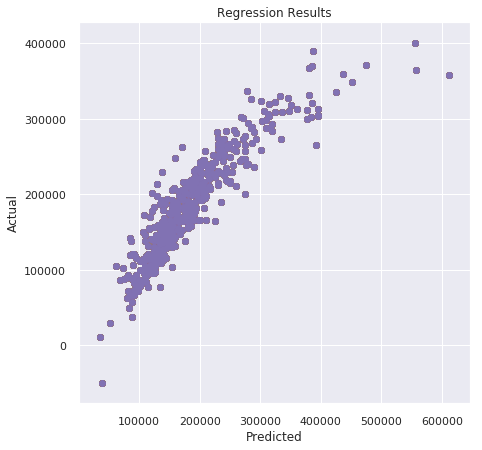

In [45]:
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=.33, random_state=420)
figure = plt.figure(figsize=(7,7))
for x in range(25):
    regressor_fit(X_train, X_test, y_train, y_test, plot=True)
# Residual
    

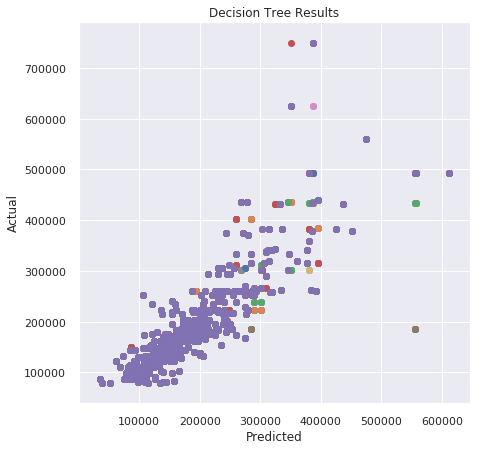

In [46]:
figure = plt.figure(figsize=(7,7))
for x in range(25):
    dtree_fit(X_train, X_test, y_train, y_test, plot=True)



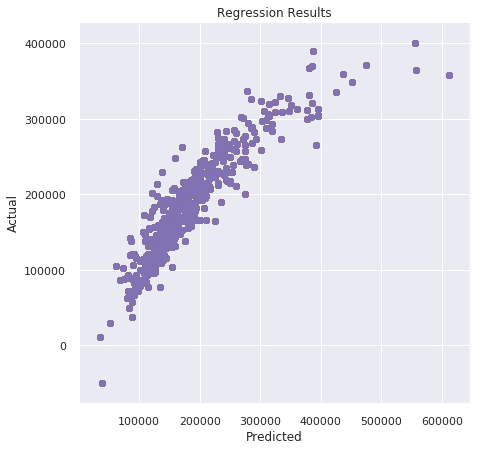

In [47]:
figure = plt.figure(figsize=(7,7))
for x in range(25):
    ridge_regressor_fit(X_train, X_test, y_train, y_test,plot=True)

## 4.2 Visualizing Accuracy between models

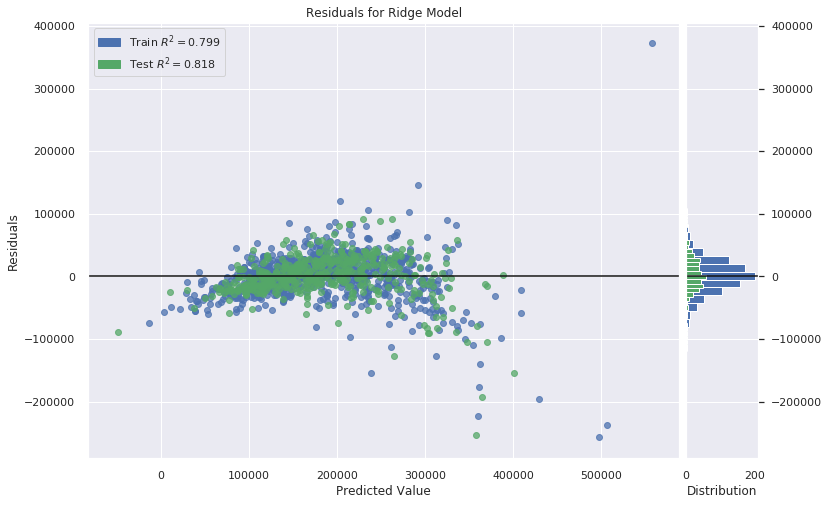

 
 The RMSE is:  33379.42105105788 



In [48]:
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=.33, random_state=420)
fig = plt.figure(figsize=(12,8))
ridge = Ridge()
visualizer = ResidualsPlot(ridge)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

ridge2 = Ridge(alpha=2)
ridge2.fit(X_train, y_train)
y_prediction = ridge2.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(" \n The RMSE is: ",RMSE,"\n")

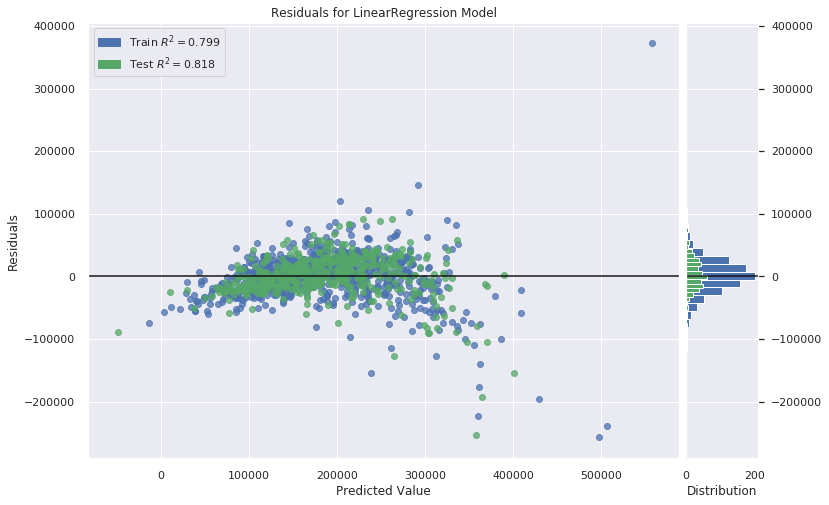

 
 The RMSE is:  33374.19746913124 



In [49]:
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=.33, random_state=420)
fig = plt.figure(figsize=(12,8))
regressor = LinearRegression()
visualizer = ResidualsPlot(regressor)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

ridge2 = LinearRegression()
ridge2.fit(X_train, y_train)
y_prediction = ridge2.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(" \n The RMSE is: ",RMSE,"\n")

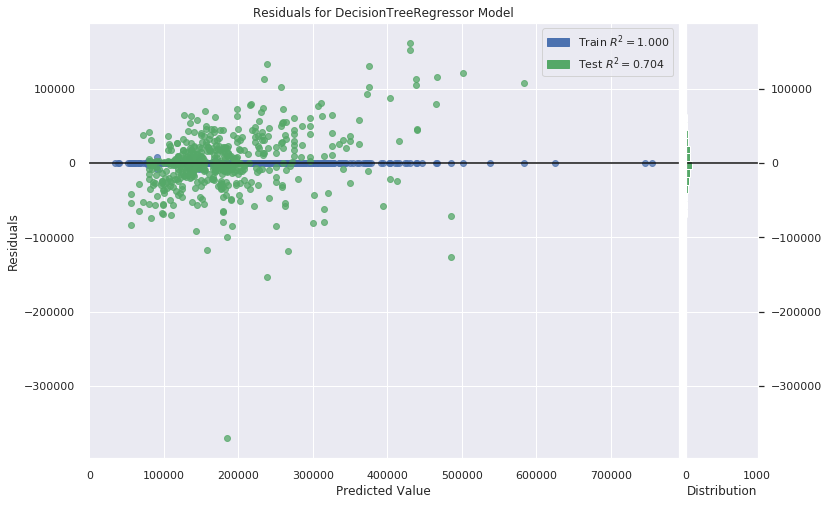

 
 The RMSE is:  42557.18995172422 



In [50]:
r_state = 100
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=.33, random_state=420)
fig = plt.figure(figsize=(12,8))
tree = DecisionTreeRegressor(random_state=r_state)
visualizer = ResidualsPlot(tree)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

ridge2 = DecisionTreeRegressor(random_state=r_state)
ridge2.fit(X_train, y_train)
y_prediction = ridge2.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(" \n The RMSE is: ",RMSE,"\n")

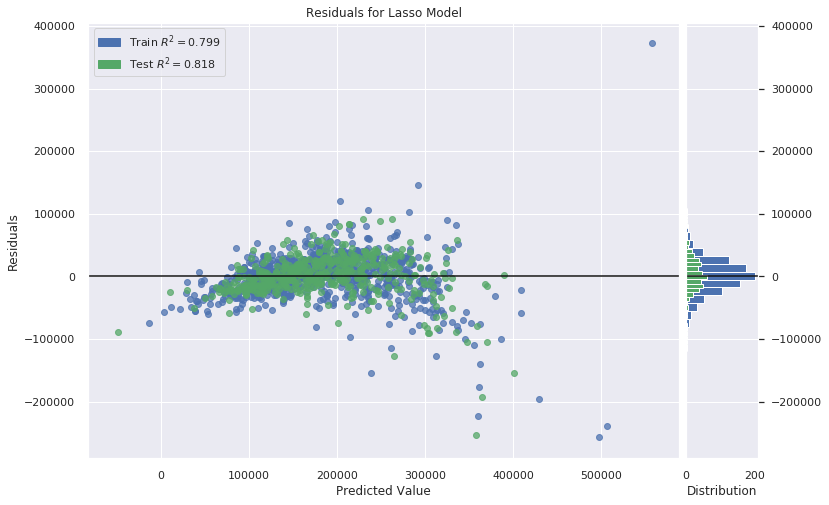

 
 The RMSE is:  33374.22559044043 



In [51]:
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=.33, random_state=420)

fig = plt.figure(figsize=(12,8))
regressor1 = Lasso(alpha=.001)
visualizer = ResidualsPlot(regressor1)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

ridge2 = Lasso(alpha = .1)
ridge2.fit(X_train, y_train)
y_prediction = ridge2.predict(X_test)
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(" \n The RMSE is: ",RMSE,"\n")

/Users/smd/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.72644e-17): result may not be accurate.
  overwrite_a=True).T
/Users/smd/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.72644e-17): result may not be accurate.
  overwrite_a=True).T


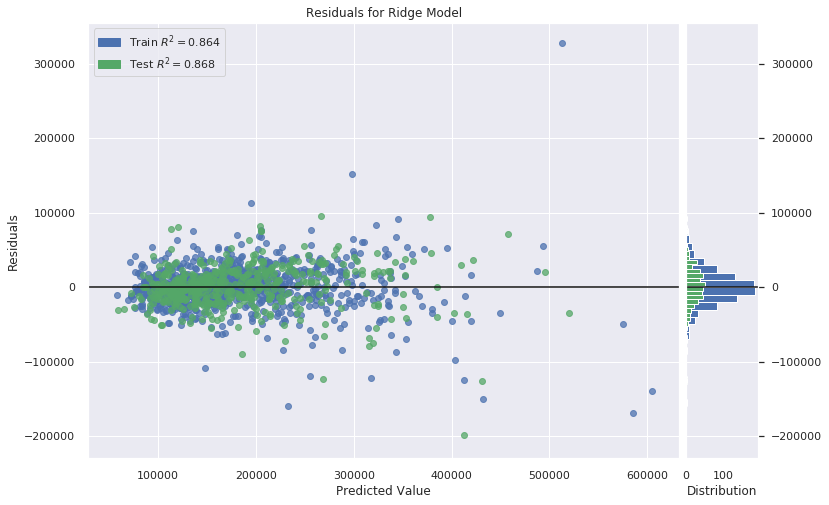

 
 The RMSE is:  28497.288482270535 



In [61]:
X = train[features]
y = train['SalePrice']
X_train, X_test, y_train, y_test =\
train_test_split(X, y, test_size=.33, random_state=420)
fig = plt.figure(figsize=(12,8))

poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)
# fit the transformed features to Linear Regression
poly_model = Ridge()
poly_model.fit(X_train_poly, y_train)

visualizer = ResidualsPlot(poly_model)
visualizer.fit(X_train_poly, y_train)
visualizer.score(X_test_poly,y_test)
visualizer.poof()

ridge2 = Ridge(alpha=.000001, normalize=True)
ridge2.fit(X_train_poly, y_train)
y_prediction = ridge2.predict(X_test_poly)
y_prediction_plot = y_prediction
RMSE = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(" \n The RMSE is: ",RMSE,"\n")

# 4.3 Model results

RMSE is the root mean square of the sum of the squared errors, it is an accurate way to quantify just how far off the mark a model is from it's predictions.

### RMSE Values

Decision Tree:             **42557.18**

RidgeRegression:           **33374.22**

Ridge Regression poly fit: **28484.39**

#### We can see that the ridge regression with the polynomial fit is the winner in this situation, with an RMSE 14,000 below that of the decision tree

In [ ]:
results = get_best_fit(features)
# Lets run it 10 times for a better estimate of the average 
# RMS across multiple random samplings
results = pd.DataFrame([get_best_fit(features) for x in range(25)])
hist_results = get_best_fit(features)
hist_predicted, hist_actual, hist_predicted_dt =\
hist_results['y_prediction'], hist_results['y_test'], hist_results['y_prediction_dt']

## 4.4 final distribution analysis

These are plots of the predicted vs actual values for each model type, so we can get a better idea of the distribution of results

#### Decison tree predicted values histogram vs actual values histogram

In [ ]:
comparison = pd.DataFrame({'reg_predicted':hist_predicted,'dt_predicted':hist_predicted_dt, 'actual':hist_actual})
plt.figure(figsize=(12,5))
sns.set(style='ticks')
ax1 = sns.distplot(comparison['actual'], color='r', label='Actual')
sns.distplot(comparison['dt_predicted'], color='y', label='DT Predicted')
[line.set_linestyle("--") for line in ax1.lines]
plt.legend()

### We can see some overfitting near the right hand tail of the decision tree distribution
This is most likely penalizing the decision tree's RMSE significantly due to the increase in the price deviation.

#### Regression predicted values histogram vs actual values histogram

In [ ]:
plt.figure(figsize=(12,5))
sns.set(style='ticks')
ax1 = sns.distplot(comparison['actual'], color='r', label='Actual')
ax2 = sns.distplot(comparison['reg_predicted'],color='b', label='regression')
plt.legend()
[line.set_linestyle("--") for line in ax1.lines]

#### Polynomial Regression predicted values histogram vs actual values histogram

In [ ]:
plt.figure(figsize=(12,5))
sns.set(style='ticks')
ax1 = sns.distplot(comparison['actual'], color='r', label='Actual')
ax2 = sns.distplot(y_prediction_plot,color='g', label='Poly Fit Regression')
plt.legend()
[line.set_linestyle("--") for line in ax1.lines]

# 5.0 Conclusion: Based on these results, the polynomial linear regression model is fitting the data better than the decision tree

While I am not certain this analysis is that statistically rigorous, I can report that the polynomial linear regressor produced a significantly lower RMSE value than did the decision tree regressor, this fact combined with the more closely approximated output result distribution, leads me to place my confidence in the polynomial linear regression model.